<a href="https://colab.research.google.com/github/41monster/ML_Spring_2023/blob/main/Example_2_MLCFD_PINN_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
import random
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# preprocessing of training dataset
# CFD data(excel) load
filename = '/content/drive/My Drive/Colab Notebooks/Dataset_example_1.00_1.01sec_3input.xlsx'
pre_dataset = pd.read_excel(filename)

# train_stats for normalization
train_stats = pre_dataset.describe()
train_stats.pop("p")
train_stats.pop("ux")
train_stats.pop("uy")
train_stats = train_stats.transpose()

# train label
dataset = pre_dataset
train_labels_p = dataset.pop("p")
train_labels_u = dataset.pop("ux")
train_labels_v = dataset.pop("uy")

# concat train labels (for subclass model)
train_labels_p_re = tf.reshape(train_labels_p, shape=[-1,1])
train_labels_u_re = tf.reshape(train_labels_u, shape=[-1,1])
train_labels_v_re = tf.reshape(train_labels_v, shape=[-1,1])
train_labels = np.concatenate((train_labels_p_re, train_labels_u_re,train_labels_v_re),axis=1)

# normalization
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']
normed_train_data = norm(dataset)
normed_train_data_re= tf.reshape(normed_train_data, shape=[-1,15])
dataset_re = tf.reshape(dataset, shape=[-1,15])

In [3]:
# input data (normed, raw)
x_sum = np.concatenate((normed_train_data_re, dataset_re[:,0:1], dataset_re[:,5:6], dataset_re[:,10:11]),axis=1)
# output data
y_sum = train_labels

from sklearn.model_selection import train_test_split
x, x_val, y, y_val = train_test_split(x_sum,y_sum,test_size=0.2, random_state = 1004)
x_pinn = x_sum
y_pinn = y_sum

In [4]:
# build 6 individual network models
# network architecture was determined in previous optimization study
net_p = keras.Sequential(
    [
        layers.Dense(64, activation='relu', input_shape=(15,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)   
    ],
    name="net_p",
)

net_u = keras.Sequential(
    [
        layers.Dense(64, activation='relu', input_shape=(15,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)   
    ],
    name="net_u",
)

net_v = keras.Sequential(
    [
        layers.Dense(64, activation='relu', input_shape=(15,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)   
    ],
    name="net_v",
)


In [14]:
# loss_tracker for monotoring during training
loss_tracker = keras.metrics.Mean(name="loss")
loss_tracker_2 = keras.metrics.Mean(name="loss")
loss_tracker_3 = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

# PINN algorithm
class FVMN_PINNs(keras.Model):
    def __init__(self, net_p, net_u, net_v, Rs, x_val=x_val, y_val=y_val, x_pinn=x_pinn, y_pinn=y_pinn):
        super(FVMN_PINNs, self).__init__()          
        self.net_p = net_p
        self.net_u = net_u
        self.net_v = net_v
        self.Rs = Rs
        self.x_val = x_val
        self.y_val = y_val
        self.x_pinn = x_pinn
        self.y_pinn = y_pinn
    
    def call(self,x):
        x = self.net_p(x)
        x = self.net_u(x)
        x = self.net_v(x)
 
    def train_step(self, data):
        x_pre, y = data
        # the order of the variables depends on the dataset.
        x = x_pre[:,0:15]
        x_ex = x_pre[:,15:18]
        x_ex = tf.cast(x_ex, dtype='float32')
        
        y_p = y[:,0:1]
        y_u = y[:,1:2] 
        y_v = y[:,2:3]
         
        with tf.GradientTape(persistent=True) as tape:
            #multi grads calculation: persistent=True
            y_pred_p = self.net_p(x)
            y_pred_u = self.net_u(x)  # Forward pass
            y_pred_v = self.net_v(x)
            
            # Calculate loss in batches.
            loss_p_mse = tf.reduce_mean(tf.square(y_p-y_pred_p), axis = 0)
            loss_u_mse = tf.reduce_mean(tf.square(y_u-y_pred_u), axis = 0)
            loss_v_mse = tf.reduce_mean(tf.square(y_v-y_pred_v), axis = 0)
                       
            # loss for training
            loss_p = loss_p_mse
            loss_u = loss_u_mse
            loss_v = loss_v_mse
            
            loss_tot = loss_p + loss_u + loss_v
        
            # conservation loss 
            x_pinn_pre = self.x_pinn
            y_pinn = self.y_pinn           
            x_pinn = x_pinn_pre[:,0:15]
            x_pinn_ex = x_pinn_pre[:,15:18]
        
            #multi grads calculation: persistent=True
            y_pred_pinn_p = self.net_p(x_pinn)
            y_pred_pinn_u = self.net_u(x_pinn)
            y_pred_pinn_v = self.net_v(x_pinn)
            
            # Residual error calculation
            y_pred_pinn_p_ex = y_pred_pinn_p + x_pinn_ex[:,0:1]
            y_pred_pinn_u_ex = y_pred_pinn_u + x_pinn_ex[:,1:2]
            y_pred_pinn_v_ex = y_pred_pinn_v + x_pinn_ex[:,2:3]
        
            y_pred_pinn_p_tf = tf.reshape(y_pred_pinn_p_ex, [180,100]) #180
            y_pred_pinn_u_tf = tf.reshape(y_pred_pinn_u_ex, [180,100])
            y_pred_pinn_v_tf = tf.reshape(y_pred_pinn_v_ex, [180,100])
            
            # continuity residual error (incompressible flow)
            y_pred_pinn_u_diff = y_pred_pinn_u_tf[2:180,1:-1] - y_pred_pinn_u_tf[0:178,1:-1] 
            y_pred_pinn_v_diff = y_pred_pinn_v_tf[1:179,2:] - y_pred_pinn_v_tf[1:179,:-2]
            
            # momentum balance residual error (incompressible flow)
            y_mom_1_tf = tf.reshape(y_pred_pinn_u, [180,100])
            y_mom_2_tf = tf.reshape(y_pred_pinn_v, [180,100])
        
            y_mom_1 = y_mom_1_tf[1:179,1:-1]
            y_mom_2 = y_mom_2_tf[1:179,1:-1]
            y_mom_3_1 = y_pred_pinn_u_tf[1:179,1:-1]
            y_mom_3_2 = y_pred_pinn_u_tf[2:180,1:-1] - y_pred_pinn_u_tf[0:178,1:-1] + y_pred_pinn_v_tf[2:180,1:-1] - y_pred_pinn_v_tf[0:178,1:-1]
            y_mom_3 = y_mom_3_1*y_mom_3_2
            y_mom_4_1 = y_pred_pinn_v_tf[1:179,1:-1]
            y_mom_4_2 = y_pred_pinn_v_tf[1:179,2:] - y_pred_pinn_v_tf[1:179,:-2] + y_pred_pinn_u_tf[1:179,2:] - y_pred_pinn_u_tf[1:179,:-2]
            y_mom_4 = y_mom_4_1*y_mom_4_2
            y_mom_5_1 = y_pred_pinn_u_tf[2:180,1:-1]-2*y_pred_pinn_u_tf[1:179,1:-1]+y_pred_pinn_u_tf[0:178,1:-1]+y_pred_pinn_v_tf[2:180,1:-1]-2*y_pred_pinn_v_tf[1:179,1:-1]+y_pred_pinn_v_tf[0:178,1:-1]
            y_mom_5_2 = y_pred_pinn_u_tf[1:179,2:]-2*y_pred_pinn_u_tf[1:179,1:-1]+y_pred_pinn_u_tf[1:179,:-2]+ y_pred_pinn_v_tf[1:179,2:]-2*y_pred_pinn_v_tf[1:179,1:-1]+y_pred_pinn_v_tf[1:179,:-2]
            y_mom_5 = 0.01*(y_mom_5_1+y_mom_5_2)
            y_mom_6 = y_pred_pinn_p_tf[2:180,1:-1] - y_pred_pinn_p_tf[0:178,1:-1] + y_pred_pinn_p_tf[1:179,2:] - y_pred_pinn_p_tf[1:179,:-2]
            
            y_mom_tot_1 = y_mom_1 + y_mom_2 + y_mom_3/2 + y_mom_4/2 - y_mom_5*100 + y_mom_6/2
        
            # due to uniform mesh
            Rs_c_1 = y_pred_pinn_u_diff + y_pred_pinn_v_diff
            Rs_c = Rs_c_1
            Rs_m = y_mom_tot_1
    
            Rs_tot_c = tf.reduce_mean(tf.square(Rs_c), axis = 0)
            Rs_tot_m = tf.reduce_mean(tf.square(Rs_m), axis = 0)
            Rs_tot = Rs_tot_c*0.1 + Rs_tot_m #0.1은 Rs_c와의 scale 보정
            
            loss_p_pinn = loss_p+ Rs_tot*0.1
            loss_u_pinn = loss_u+ Rs_tot*0.1
            loss_v_pinn = loss_v+ Rs_tot*0.1
            
            loss_tot_pinn = loss_p_pinn + loss_u_pinn + loss_v_pinn
        
        # Compute gradients
        trainable_vars_p = self.net_p.trainable_variables
        trainable_vars_u = self.net_u.trainable_variables
        trainable_vars_v = self.net_v.trainable_variables 
        
        gradients_p = tape.gradient(loss_p_pinn, trainable_vars_p)
        gradients_u = tape.gradient(loss_u_pinn, trainable_vars_u)
        gradients_v = tape.gradient(loss_v_pinn, trainable_vars_v)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients_p, trainable_vars_p))
        self.optimizer.apply_gradients(zip(gradients_u, trainable_vars_u))
        self.optimizer.apply_gradients(zip(gradients_v, trainable_vars_v))
        
        #validation loss
        x_val = self.x_val
        y_val = self.y_val 

        x_val_2 = x_val[:,0:15]      
        y_val_p = y_val[:,0:1]
        y_val_u = y_val[:,1:2] 
        y_val_v = y_val[:,2:3]
        
        y_val_pred_p = self.net_p(x_val_2)
        y_val_pred_u = self.net_u(x_val_2)  # Forward pass
        y_val_pred_v = self.net_v(x_val_2)
    
        loss_val_p_mse = tf.reduce_mean(tf.square(y_val_p-y_val_pred_p), axis = 0)
        loss_val_u_mse = tf.reduce_mean(tf.square(y_val_u-y_val_pred_u), axis = 0)
        loss_val_v_mse = tf.reduce_mean(tf.square(y_val_v-y_val_pred_v), axis = 0)
        
        val_loss = loss_val_p_mse + loss_val_u_mse + loss_val_v_mse
    
        #validation loss = validation loss + conservation error
        #Rs = self.Rs
        #val_loss = val_loss_pre + Rs_tot*Rs
    
        # loss, mse for epochs monitoring
        loss_tracker.update_state(val_loss) #Rs_tot
        loss_tracker_2.update_state(Rs_tot)
        loss_tracker_3.update_state(loss_tot)

        #mae_metric.update_state(y_u, y_pred_u)            
        #return {"loss": loss_tracker.result(), "mae": mae_metric.result()}          
        return {"custom_val_loss": loss_tracker.result(), "Rs_tot": loss_tracker_2.result(), "custom_loss_tot": loss_tracker_3.result()}

    @property
    #1epoch 1 initialization: https://stackoverflow.com/questions/57248723/why-there-is-sudden-drop-in-loss-after-every-epoch
    def metrics(self):
        return [loss_tracker, loss_tracker_2, loss_tracker_3] # `reset_states()` can be called automatically at the start of each epoch

In [15]:
import os
checkpoint_path =  './MLCFD-PINN_test'

checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True, save_best_only=True, monitor = 'custom_val_loss',
                                   verbose=1)

In [7]:
# check data size
print(tf.shape(x))
print(tf.shape(y))
print(tf.shape(x_val))
print(tf.shape(y_val))
print(tf.shape(x_pinn))
print(tf.shape(y_pinn))

tf.Tensor([14400    18], shape=(2,), dtype=int32)
tf.Tensor([14400     3], shape=(2,), dtype=int32)
tf.Tensor([3600   18], shape=(2,), dtype=int32)
tf.Tensor([3600    3], shape=(2,), dtype=int32)
tf.Tensor([18000    18], shape=(2,), dtype=int32)
tf.Tensor([18000     3], shape=(2,), dtype=int32)


In [17]:
# model fit
model = FVMN_PINNs(net_p=net_p, net_u=net_u,net_v=net_v, Rs =0.001, x_val=x_val, y_val=y_val, x_pinn = x_pinn,y_pinn = y_pinn )
#model.compile(optimizer= 'adam' )
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001) )
history = model.fit(x, y,batch_size=100, epochs=5, callbacks=[cp_callback]) # no validation data arguments

Epoch 1/5
144/144 [==============================] - ETA: 0s - custom_val_loss: 9.5612 - Rs_tot: 85.5241 - custom_loss_tot: 9.4901
Epoch 1: custom_val_loss did not improve from 9.52460
144/144 [==============================] - 10s 59ms/step - custom_val_loss: 9.5610 - Rs_tot: 85.5238 - custom_loss_tot: 9.4902
Epoch 2/5
144/144 [==============================] - ETA: 0s - custom_val_loss: 9.4857 - Rs_tot: 85.6689 - custom_loss_tot: 9.4714
Epoch 2: custom_val_loss improved from 9.52460 to 9.52180, saving model to ./MLCFD-PINN_test
144/144 [==============================] - 8s 57ms/step - custom_val_loss: 9.4860 - Rs_tot: 85.6660 - custom_loss_tot: 9.4714
Epoch 3/5
143/144 [============================>.] - ETA: 0s - custom_val_loss: 9.4418 - Rs_tot: 85.7609 - custom_loss_tot: 9.4445
Epoch 3: custom_val_loss improved from 9.52180 to 9.51115, saving model to ./MLCFD-PINN_test
144/144 [==============================] - 9s 66ms/step - custom_val_loss: 9.4428 - Rs_tot: 85.7558 - custom_loss_

In [18]:
# check val_loss with epoch
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,custom_val_loss,Rs_tot,custom_loss_tot,epoch
0,9.538097,85.472145,9.494598,0
1,9.521800,85.261658,9.479051,1
2,9.511150,85.387199,9.457859,2
3,9.488312,84.931717,9.454182,3
4,9.488510,85.079620,9.443867,4


Text(0, 0.5, 'Predictions')

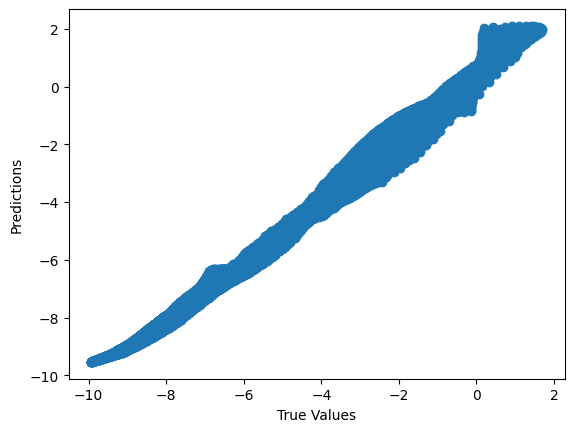

In [24]:
import matplotlib.pyplot as plt
# prediction for training datset
model.load_weights("./MLCFD-PINN_test")

# train data results plot
x_pinn_test=x_pinn[:,0:15]
y_pinn_test=y_pinn[:, 0:1]
train_predictions = model.net_p(x_pinn_test)

plt.scatter(y_pinn_test, train_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')